In [114]:
from PIL import Image
import numpy as np
import os
import scipy
from mpldatacursor import datacursor
from scipy import ndimage
import warnings,glob
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    %matplotlib nbagg
    import matplotlib.pyplot as plt
    import matplotlib
files = glob.glob("/Users/rein/Desktop/m51/2017-07-27/full*iso1600_shutter30s.jpg")[0:60]
dark = np.load("dark.npy")
flat = np.load("flat.npy")
print(len(files))

60


<IPython.core.display.Javascript object>


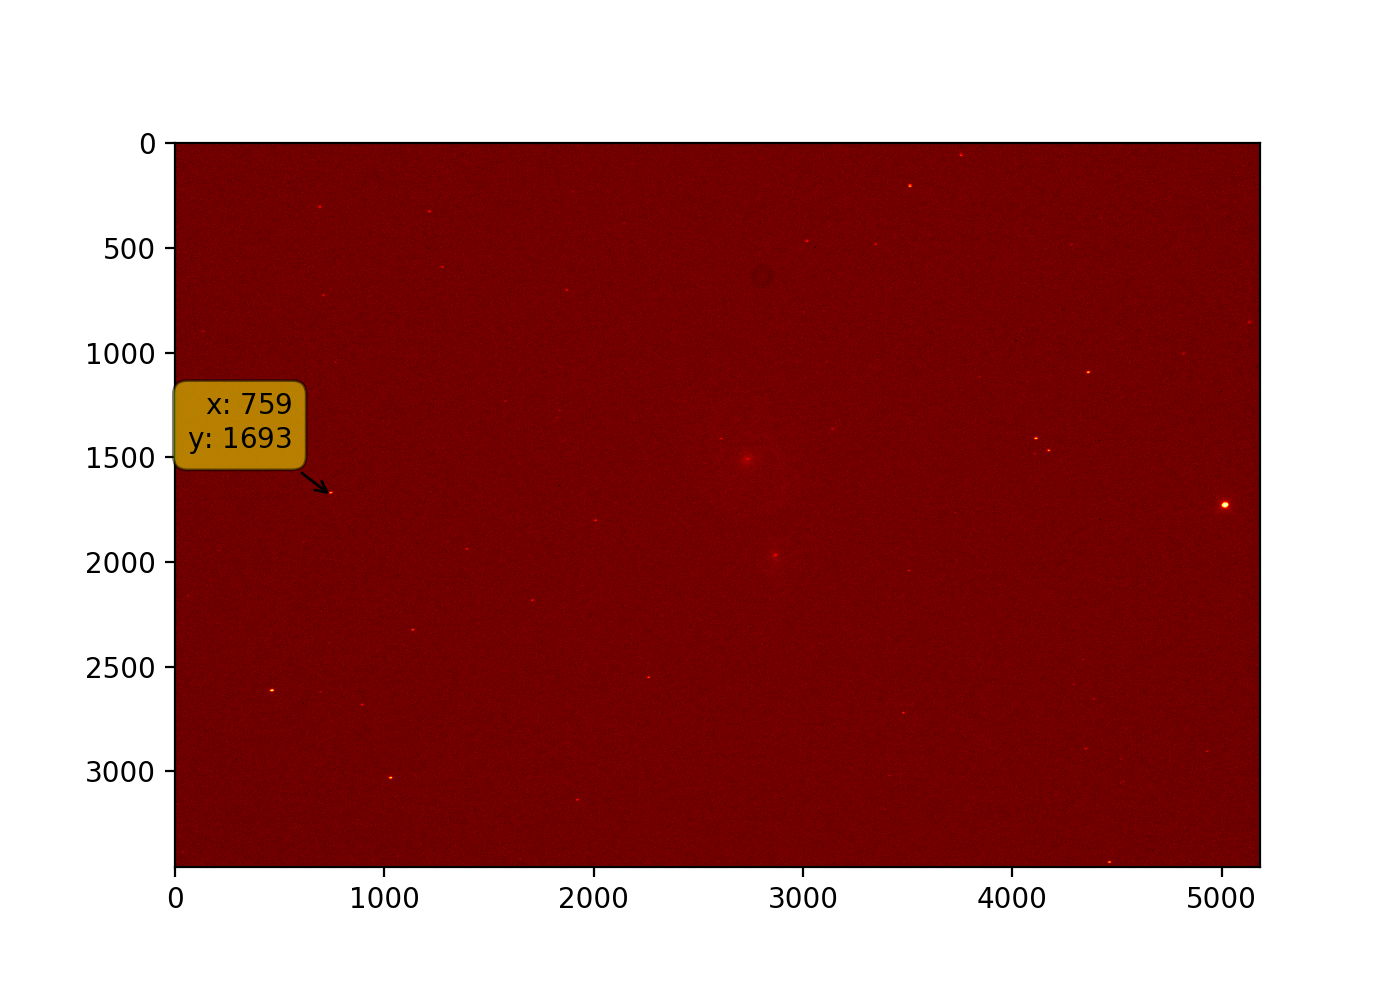

In [115]:
f = files[0]
refi = np.average((np.array(Image.open(f), dtype=np.float32)-dark)/flat,axis=2)
fig, ax = plt.subplots(figsize=(7,5))
ax.imshow(refi, cmap="hot")
dc = datacursor(ax)

In [116]:
for k in dc.annotations:
    ry, rx = dc.annotations[k].xy
    print(rx, ry)
radius = 150

1692.56175115 759.033640553


In [117]:
def cmask(x,y,radius,shape):
    nx,ny = shape
    y,x = np.ogrid[-x:nx-x,-y:ny-y]
    mask = x*x + y*y >= radius*radius
    return mask
mask = cmask(rx,ry,radius,refi.shape)
blurred = scipy.ndimage.filters.gaussian_filter(refi, sigma=10)
am = np.argmax(np.ma.masked_array(blurred,mask))
refx, refy = np.unravel_index(am,refi.shape)
print(refx,refy)

1669 744


In [131]:
ar, ag, ab = np.average(np.average(flat-dark,axis=0),axis=0)
avg = np.dstack((np.full(flat.shape[0:2],ar),np.full(flat.shape[0:2],ag),np.full(flat.shape[0:2],ab)))

In [132]:
sr, sg, sb = None, None, None
shifts = np.zeros((len(files),2))
for j,f in enumerate(files):
    #i = np.average((np.array(Image.open(f), dtype=np.float32)),axis=2)
    i = (np.array(Image.open(f), dtype=np.float32)-dark)/(flat-dark)*avg
    ir, ig, ib = i[:,:,0], i[:,:,1], i[:,:,2]
    blurred = scipy.ndimage.filters.gaussian_filter(ir, sigma=10)
    am = np.argmax(np.ma.masked_array(blurred,mask))
    ix, iy = np.unravel_index(am,ir.shape)
    shifts[j] = [ix-refx,iy-refy]
    ir = np.roll(ir,-iy+refy,axis=1)
    ir = np.roll(ir,-ix+refx,axis=0)
    ig = np.roll(ig,-iy+refy,axis=1)
    ig = np.roll(ig,-ix+refx,axis=0)    
    ib = np.roll(ib,-iy+refy,axis=1)
    ib = np.roll(ib,-ix+refx,axis=0)        
    if sr is None:
        sr = ir
        sg = ig
        sb = ib
    else:
        sr += ir
        sg += ig
        sb += ib

In [133]:
sr/=len(files)
sg/=len(files)
sb/=len(files)

<IPython.core.display.Javascript object>


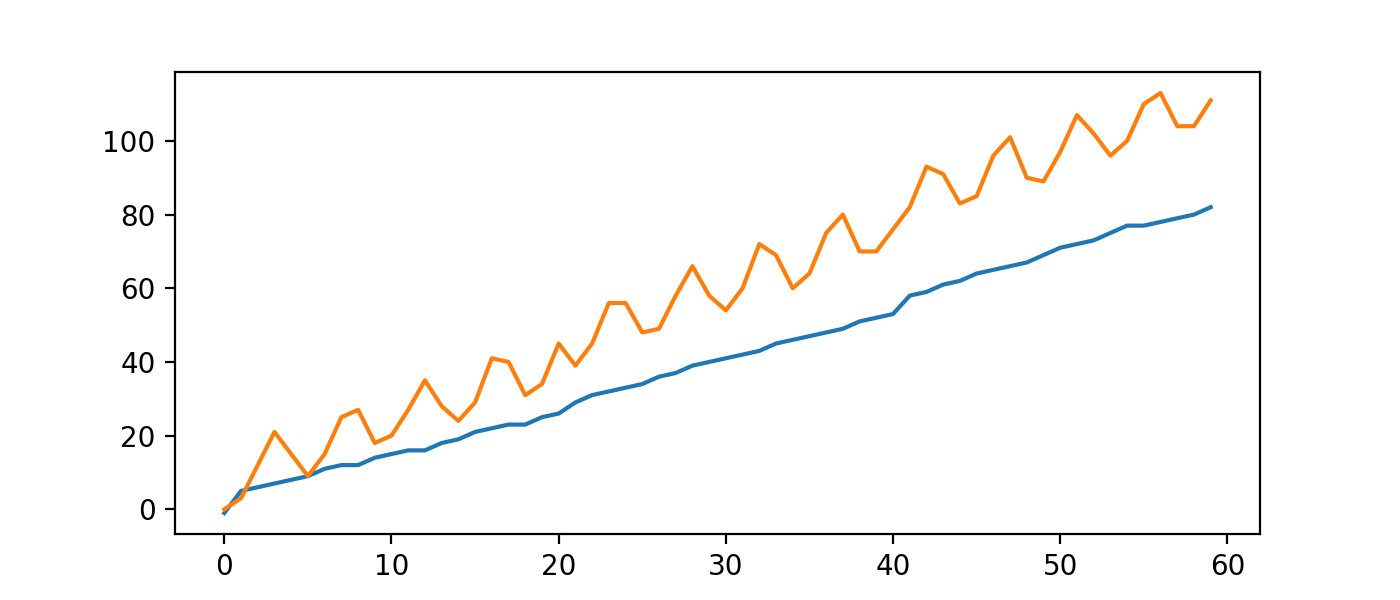

In [134]:
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(shifts[:,0])
ax.plot(shifts[:,1])

<IPython.core.display.Javascript object>


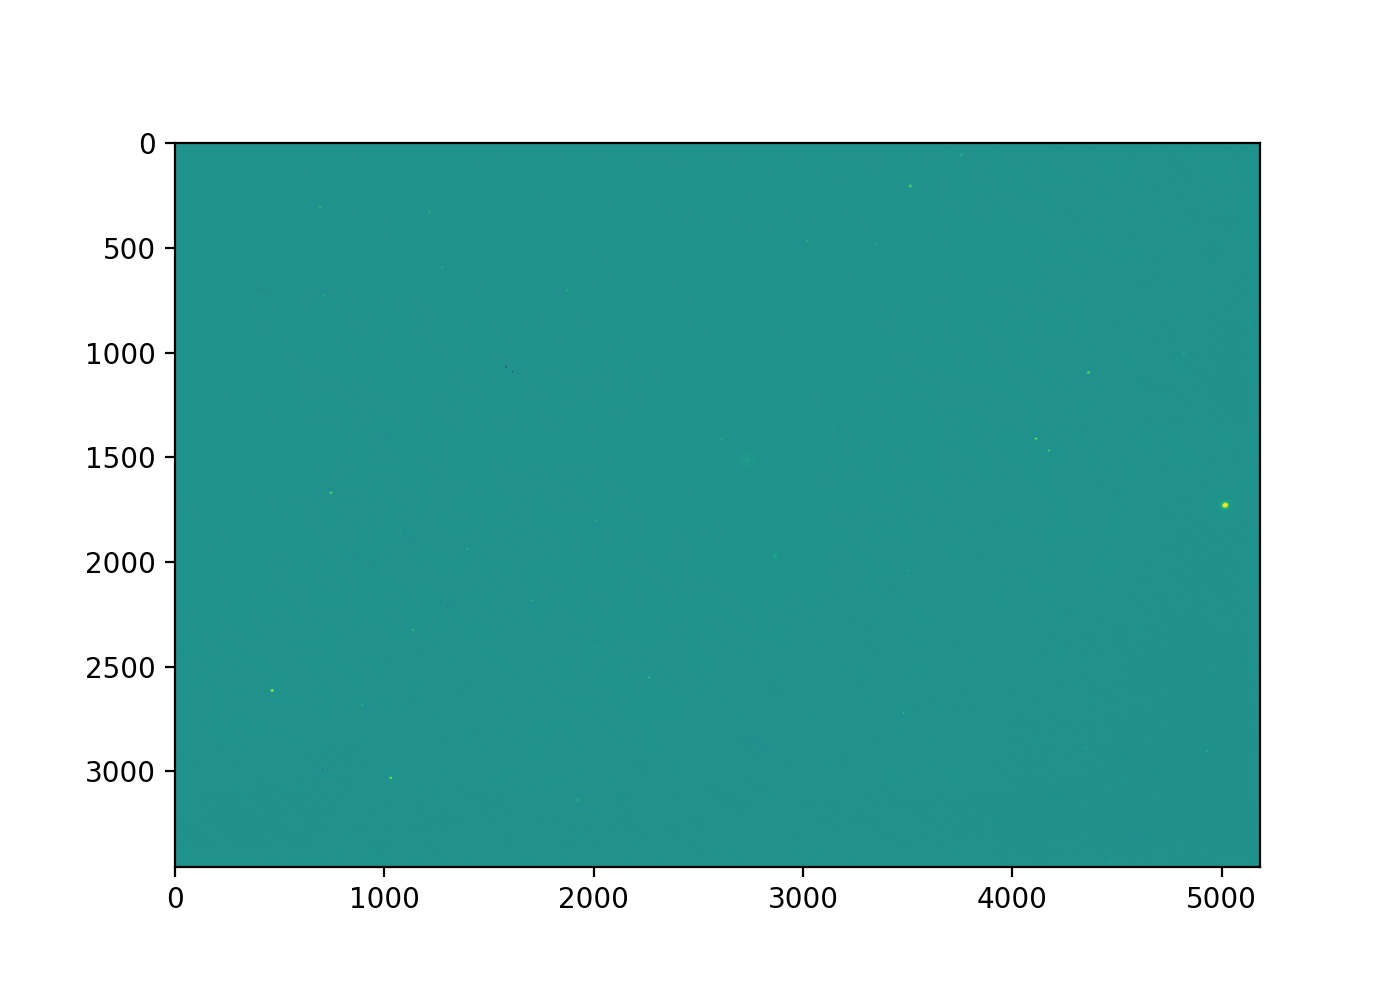

(3456, 5184, 3)


In [135]:
fig, ax = plt.subplots(figsize=(7,5))
ss = np.dstack((sr,sg,sb))
print(ss.shape)
ax.imshow(ss[:,:,2])

In [113]:
def normi(i):
    nmin, nmax = np.percentile(i,0.01),np.percentile(i,99.97)
    return (i-nmin)/(nmax-nmin)
ss = np.dstack((normi(sr),normi(sg),normi(sb)))
scipy.misc.toimage(np.sqrt(ss),cmin=0.,cmax=1.).save('stacked.jpg')

/Users/rein/git/rebound/venv/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt


In [142]:
ss = np.dstack((sr,sg,sb))
scipy.misc.toimage(ss,cmin=40.,cmax=110.).save('stacked.jpg')

In [18]:
smin = np.min(s)
smax = np.max(s)
p = np.log((s-smin)/(smax-smin))

vmin, vmax = np.percentile(p,10),np.percentile(p,99.927)
print(vmin,vmax)

/Users/rein/git/rebound/venv/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


-3.56931090355 -2.19411873817


<IPython.core.display.Javascript object>


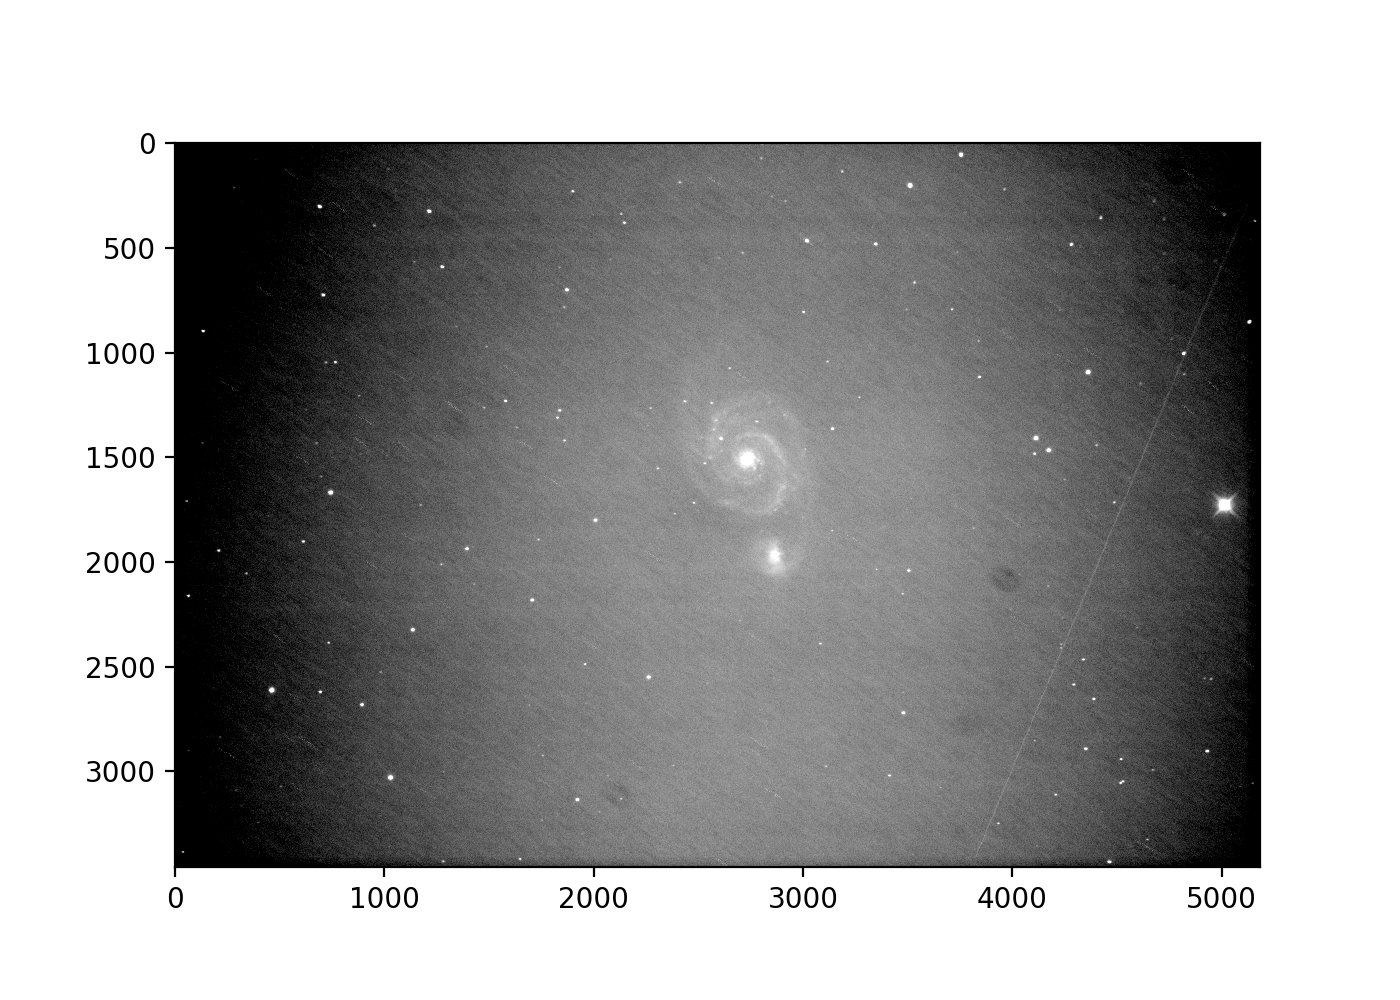

In [19]:
fig, ax = plt.subplots(figsize=(7,5))
ax.imshow(p, vmin=vmin,vmax=vmax,cmap="gray")

In [339]:
scipy.misc.toimage(p, cmin=vmin, cmax=vmax).save('stacked.jpg')


In [311]:
white = np.array(Image.open("white.jpg"), dtype=np.float32)
wr,wg,wb=np.max(np.max(white,axis=0),axis=0)
ones = np.ones((white.shape[0],white.shape[1]))
white /= np.stack([wr*ones, wg*ones, wb*ones],axis=2)

In [315]:
np.max(np.min(white,axis=0),axis=0)

array([ 0.6958763 ,  0.52499998,  0.34782609], dtype=float32)